# About this Notebook

Object Detection is a problem which is not only a bit complex but also computationally expensive, due to the number of components to it. I always wanted to learn it and I got really excited when I saw a Kaggle competition on it , although I was not able to fully concentrate on it due to other competitions up untill now. While I was learning all the different concepts in Object Detection , I came across Facebook's **Detection tranformer DETR** , launched in April 2020 . It's still quite new but the resuts are astonishing and the model itself is very fast . In this notebook, I explore this new architecture,its working and fine tune it for Wheat Detection competition Dataset.

Note that for now this is just a baseline to demonstrate the architecture and its working ,it does not aim at getting very good results on lb,this will be a work in progress,and I will soon update with full training and a separate 

# Update Log

### V2
* As I was made aware that I was printing the target boxes instead of predicted boxes , I have corrected it , I am really sorry , It was an honest mistake
* Thanks to PRVI and his valuable suggestions , I have incorporated the following changes :
  * Normalizing bounding boxes
  * Using label 0 for main class

The code for the changes has been taken from [here](https://www.kaggle.com/prokaj/end-to-end-object-detection-with-transformers-detr#Creating-Dataset)

# DETR (Detection Transformer)

Attention is all you need,paper for Transformers,changed the state of NLP and has achieved great hieghts. Though mainly developed for NLP , the latest research around it focuses on how to leverage it across different verticals of deep learning. Transformer acrhitecture is very very powerful, and is something which is very close to my part,this is the reason I am motivated to explore anything that uses transformers , be it google's recently released Tabnet or OpenAI's ImageGPT .

Detection Transformer leverages the transformer network(both encoder and the decoder) for Detecting Objects in Images . Facebook's researchers argue that for object detection one part of the image should be in contact with the other part of the image for greater result especially with ocluded objects and partially visible objects, and what's better than to use transformer for it.

**The main motive behind DETR is effectively removing the need for many hand-designed components like a non-maximum suppression procedure or anchor generation that explicitly encode prior knowledge about the task and makes the process complex and computationally expensive**

The main ingredients of the new framework, called DEtection TRansformer or DETR, <font color='green'>are a set-based global loss that forces unique predictions via bipartite matching, and a transformer encoder-decoder architecture.</font>

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/Screenshot-from-2020-05-27-17-48-38.png)

<font color='red'>Interesting Right?? Want to learn more please bare with me, as always I will try to explain everything</font>

For Fully understanding DETR I recommend read [this](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/) blog<br><br>
However if you want in-depth knowledge and are a video person like please see the video in the cell below
You can find the video in youtube [here](https://www.youtube.com/watch?v=T35ba_VXkMY)

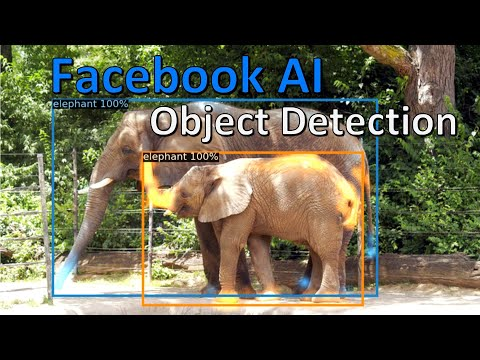

In [1]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('T35ba_VXkMY',width=600, height=400)

# Using DETR without Fine-Tuning

* Before learning how to fine tune DETR if you want to use and play with DETR directly on some sample images , please refer the video [here](https://www.youtube.com/watch?v=LfUsGv-ESbc)
* [Here](https://scontent.flko3-1.fna.fbcdn.net/v/t39.8562-6/101177000_245125840263462_1160672288488554496_n.pdf?_nc_cat=104&_nc_sid=ae5e01&_nc_ohc=KwU3i7_izOgAX9bxMVv&_nc_ht=scontent.flko3-1.fna&oh=64dad6ce7a7b4807bb3941690beaee69&oe=5F1E8347) is the link to the paper
* [Here](https://github.com/facebookresearch/detr) is link to their github repo for code and model zoo
* They recently added a wrapper to use DETR from Detectron2 API

# Wheat Detection Competition With DETR

So I wanted to try DETR and what could be greater oppurtunity than a kaggle competition to test a model's potential. I just joined two days ago and from what I have analyzed these are by far the best practices for this competition :-
* Use Stratified Kfold because of different sources of Images
* Use Cut-mix for better model generalization
* Use WBF ensemble for unifying predictions of Kfold model

Besides these I found gem of an EDA kernel , It gives very valuable insigts , you can have a look [here](https://www.kaggle.com/aleksandradeis/globalwheatdetection-eda) by aleksandra .Here are the conclusions derived from that kernel
* Images are taken at different zoom levels. Crop and resize data augmentations to be used for model training.
* Images are taken at various lighting conditions. Special filters should be used to address that.
* Bounding boxes are messy!

**There are some Giant bounding boxes and some micro bounding boxes removal of which have reported bad lb, so I assume the noise is present in the test setas well, hence keeping them would be more benificial**

Keeping all this in find we start with coding DETR , **Note that this code can be used and easily modified to other object detection tasks**

In [2]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

Cloning into 'detr'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 162 (delta 10), reused 23 (delta 6), pack-reused 127
Receiving objects: 100% (162/162), 12.82 MiB | 32.33 MiB/s, done.
Resolving deltas: 100% (68/68), done.


* Now if you have seen the video , you know that DETR uses a special loss called Bipartite Matching loss where it assigns one ground truth bbox to a predicted box using a matcher , thus when fine tuning we need the matcher (hungarian matcher as used in paper) and also the fucntion SetCriterion which gives Bipartite matching loss for backpropogation. This is the reason for forking the github repo

* So I did not know that we can add the path to environment variables using sys , hence I was changine directories , but now I have made changes so I do not have to change directories and import detr easily. A big Thanks to @prvi for his help

In [3]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

In [5]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 2

# Seed Everything

Seeding everything for reproducible results

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [7]:
seed_everything(seed)

# Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here](https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [8]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [9]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


# Augmentations

* As suggested by aleksendra in her kernel ,augentations will play a major role and hence took her up advice and use awesome augmentations , cut-mix and other will be included in future versions

In [10]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
                      
                      A.ToGray(p=0.01),
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      
                      A.Resize(height=512, width=512, p=1),
                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                      
                      ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

# Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [11]:
DIR_TRAIN = '../input/global-wheat-detection/train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [12]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [13]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

# Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [14]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

# Eval Function

In [15]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

# Engine

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = WheatDataset(
    image_ids=df_train.index.values,
    dataframe=marking,
    transforms=get_train_transforms()
    )

    valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')

In [18]:
run(fold=0)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth



|EPOCH 1| TRAIN_LOSS 1.3868379712810177| VALID_LOSS 1.0091161573634428|
Best model found for Fold 0 in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 1.0485429814934024| VALID_LOSS 0.9041734765557682|
Best model found for Fold 0 in Epoch 2........Saving Model


# Sample

* I know we might be naive to visualize the model ouput just after one epoch but lets do that and see what are the results like

In [19]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    
    for box,p in zip(oboxes,prob):
        
        if p >0.5:
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


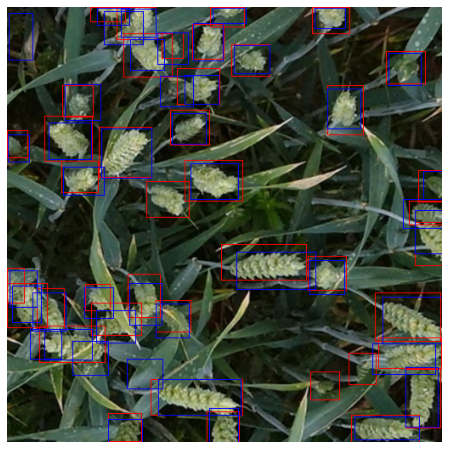

In [20]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 0],model=model,device=torch.device('cuda'))

# End Notes

I will further add information about various losses that DETR uses , how is criterion declared , what are its parameters exactly,what is hungarian matcher , a little intuition

* We trained one epoch that too for a single fold, but  Detr seems to work fairly well.
* I hope you liked my effort , trying hands with this new model 
* If this kernel receives love,I plan to fine tune DETR,run all five folds and publish an inference kernel using WBF for this competition, I belive this can score above 0.74 without any pseudo labelling tricks
* I also plan to include visualization of attentionn weights in the next version along with first fold fully trained on 30-35 epochs with a good lr scdeduler
* I tried to write a genric code so that this can be used with any general object detection dataset and tasks


<font color='red'>Please consider upvoting if my efforts helped you or made you excited about DETR</font>